We need to understand in detail the numbers we are using to evaluate the performance of YOLACT. These are computed inside eval.py using the APDataObject class. 

Here is the code for APDataObject, copied from eval.py:


is this under git?


In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

class APDataObject:
    """
    Stores all the information necessary to calculate the AP for one IoU and one class.
    Note: I type annotated this because why not.
    
    WJP: I added the classname arg to the init. Could be handy! 
    """

    def __init__(self, cname = None):
        self.classname = cname
        self.data_points = []
        self.num_gt_positives = 0

    def push(self, score:float, is_true:bool):
        self.data_points.append((score, is_true))
    
    def add_gt_positives(self, num_positives:int):
        """ Call this once per image. """
        self.num_gt_positives += num_positives

    def is_empty(self) -> bool:
        return len(self.data_points) == 0 and self.num_gt_positives == 0

    def get_ap(self) -> float:
        """ Warning: result not cached. """

        if self.num_gt_positives == 0:
            return 0

        # Sort descending by score
        self.data_points.sort(key=lambda x: -x[0])

        precisions = []
        recalls    = []
        num_true  = 0
        num_false = 0

        # Compute the precision-recall curve. The x axis is recalls and the y axis precisions.
        print('fixing indent, num_gt_positves is', self.num_gt_positives)
        for datum in self.data_points:
            # datum[1] is whether the detection is a true or false positive, set is
            if datum[1]:  
                num_true += 1
            else:
                num_false += 1
            
        precision = num_true / (num_true + num_false)
        recall    = num_true / self.num_gt_positives

        precisions.append(precision)
        recalls.append(recall)
        print(len(precisions), len(recalls))

    # Smooth the curve by computing [max(precisions[i:]) for i in range(len(precisions))]
        # Basically, remove any temporary dips from the curve.
        # At least that's what I think, idk. COCOEval did it so I do too.
        for i in range(len(precisions)-1, 0, -1):
            if precisions[i] > precisions[i-1]:
                precisions[i-1] = precisions[i]

        # Compute the integral of precision(recall) d_recall from recall=0->1 using fixed-length riemann summation with 101 bars.
        y_range = [0] * 101 # idx 0 is recall == 0.0 and idx 100 is recall == 1.00
        x_range = np.array([x / 100 for x in range(101)])
        recalls = np.array(recalls)

        # I realize this is weird, but all it does is find the nearest precision(x) for a given x in x_range.
        # Basically, if the closest recall we have to 0.01 is 0.009 this sets precision(0.01) = precision(0.009).
        # I approximate the integral this way, because that's how COCOEval does it.
        indices = np.searchsorted(recalls, x_range, side='left')
        for bar_idx, precision_idx in enumerate(indices):
            if precision_idx < len(precisions):
                y_range[bar_idx] = precisions[precision_idx]

        # Finally compute the riemann sum to get our integral.
        # avg([precision(x) for x in 0:0.01:1])
        return sum(y_range) / len(y_range)



In the code above, I moved the block that appends to precisions and recalls out of the loop over data_points. Why compute a new recall with the same num_gt_positives. Of *course* it grows with every data_point. I do not get it. 

In [34]:
with open('./results/53560.txt','rb') as f:
    apdump = pickle.load(f)

print(type(apdump))
print(apdump.keys())

<class 'dict'>
dict_keys(['box', 'mask'])


In [35]:
apd = apdump['mask'][0][23]
print(apd.get_ap())
print('num_gt_positives is',apd.num_gt_positives)

fixing indent, num_gt_positves is 17
1 1
0.030909090909090886
num_gt_positives is 17


In [3]:
# apdump is a dict, with keys mask and box
apbox = apdump['box']

# each value is a list with 10 entries...recall bins? 
print(type(apbox), len(apbox))
# each of the 10 entries is a list of APDataObjects, one APDataObject for each type of lab object
print(type(apbox[0]), len(apbox[0]))
print(type(apbox[0][0]))
ap0 = apbox[0][0]


<class 'list'> 10
<class 'list'> 47
<class '__main__.APDataObject'>


The APDataObject class has some distinctive attributes (besides a bunch of regular python ones). These are:
'add_gt_positives', 'data_points', 'get_ap', 'is_empty', 'num_gt_positives', and 'push'. 

There is one APDataObject for each type of lab object. 

I think data_points must contain something important! I think there is a data_point list item for each detection of the object type to which a give APDataObject pertains. 

In [38]:
print(type(ap0.data_points))
print(len(ap0.data_points))

ap0.data_points[42:47]

<class 'list'>
491


[(5.093637082609348e-05, False),
 (2.6293258770238026e-07, False),
 (2.0173038137727417e-06, False),
 (1.2819658877560869e-05, False),
 (5.477535887621343e-05, False)]

Is the first number in the tuple the IoU value? How do we get numbers of order 1 out of this? 



In [39]:
print(type(ap0.data_points[0]))
print(len(ap0.data_points[0]))
print(type(ap0.data_points[0][0]))
print(type(ap0.data_points[0][1]))

<class 'tuple'>
2
<class 'numpy.float64'>
<class 'bool'>


In [5]:
ap0.get_ap()


1.0

THe follwing function and the commands that call it show that we can change an argument inside a function. So that one of the inputs to the function gets mysteriously changed. ARGH. It's 1985 again, and we have "output parameters". I think I will write my elected representatives about this. 

Even if there is some good reason for allowing this, it shouldn't be done so sneakily. But it's literally part of the way we get these performance numbers computed. 

In [29]:
def f(stuff):
    stuff.append('junk')
    return
    

In [33]:
crap = [1,2,3]
print(id(crap))
foo = f(crap)
print(id(crap))
print(id(foo))
print(crap)
print(foo)

2160725842568
2160725842568
140722273934560
[1, 2, 3, 'junk']
None


I added classname to the APDataObject. I guess I should re-paste the code above! Ok, I did it. 


In [6]:
with open('./results/ap_data.pkl','rb') as f:
    apd = pickle.load(f)



In [7]:
classes = [apo.classname for apo in apd['mask'][0]]

In [8]:
classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [9]:
len(apd['mask'][9])

80

Ok, now let's do some precision vs. recall stuff. We want to do this for both masks and boxes. In the following I will generated lists of 10 precision values, corresponding to the 10 recall bins that are somehow created in YOLACT. They use a list of thresholds to do this, so I think each bin might actually be the ap for "recall >= x" where x is 10 evenly spaced thresholds starting at 0.5. And I still don't know how recall is computed.

In [10]:
PvsRmask = []
PvsRbox = []

for j in range(80):
    PvsRmask.append(np.asarray([apd['mask'][i][j].get_ap() for i in range(10)]))
    PvsRbox.append(np.asarray([apd['box'][i][j].get_ap() for i in range(10)]))

In [16]:
print(PvsRmask[0])
len(PvsRmask)

[0.49726158 0.46025366 0.41873464 0.36790234 0.31313665 0.24735133
 0.16996742 0.0896729  0.02538226 0.0013018 ]


80

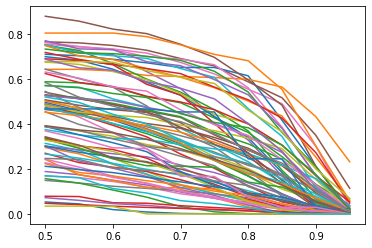

In [20]:
recall_bins = np.linspace(0.5,0.95,10)
[plt.plot(recall_bins, pvr) for pvr in PvsRmask];

In [82]:
boxsum = np.zeros((10,))
for j in range(80):
    boxsum = boxsum + PvsRbox[j]/80.0

In [83]:
boxsum

array([0.49399848, 0.47109325, 0.44333414, 0.40908616, 0.36776282,
       0.31463857, 0.24283732, 0.16064792, 0.06755672, 0.0076687 ])

Each of the datapoints entries in ap_data is a tuple of two things. The first is a number, the IoU for mask or box. The second is a boolean, which I *think* is for whether or not the class label is correct on a given detection. Like, the label from pred has to match the label from gt. 